In [1]:
from scipy import *
import numpy as np
from pylab import *
from scipy.interpolate import interp1d
import os
from astropy.io import fits
from scipy.special import factorial
from classy import Class
%matplotlib inline

# Fiducial parameters

In [2]:
######## check TT, Pk (z=0), Clkk (z=1) from class vs camb

# LCDM parameters
A_s = 2.1e-9
h=0.7
OmegaB = 0.046
OmegaM = 0.3
n_s = 0.97
tau = 0.054 ## only for primary CMB, not used for now

# beyond LCDM, not implemented 
OmegaDE = 0.75
w0=-1.0#-0.5#
wa=0.0#0.1#
Neff = 3.046
mnu = 0.0

### derived parameters
#z_reio = 10.0 #11.357
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100
### accuracy parameters
lmax=5000

# Generate Clkk from class

In [115]:
######### turn the class code into a function taking any As and omega_m
def clkk_gen (Omega_m, A_se9, zs=1.0):
    A_s = A_se9*1e-9
    omch2 = (OmegaM-OmegaB)*h**2
    LambdaCDM = Class()
    LambdaCDM.set({'omega_b':ombh2,'omega_cdm':omch2,'h':h,'A_s':A_s,'n_s':n_s})
    LambdaCDM.set({'output':'mPk,sCl',
                   'P_k_max_1/Mpc':10.0,
                   #'z_pk':0,
                   #'reio_parametrization':'reio_none',
                   'l_switch_limber':100,
                   'selection':'dirac',
                   'selection_mean':zs,
                   'l_max_lss':lmax,
                   'non linear':'halofit'
                  })
    # run class
    LambdaCDM.compute()

    si8=LambdaCDM.sigma8()

    cls=LambdaCDM.density_cl(lmax)
    #print cls.viewkeys()
    ell=cls['ell'][2:]
    clphiphi=cls['ll'][0][2:]
    clkk=1.0/4 * (ell+2.0)*(ell+1.0)*(ell)*(ell-1.0)*clphiphi

    return si8, ell, clkk

In [116]:
si8,ell,clkk = clkk_gen (0.3, 2.1)

Text(0.5,1,'2020/3/12 Clkk test (z_s=1)')

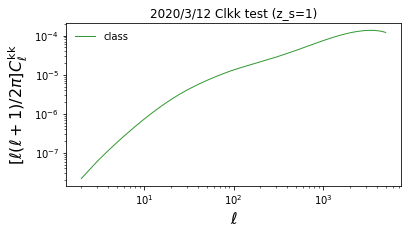

In [117]:
figure(3, figsize=(6,3))
xscale('log');yscale('log');#xlim(2,2500)
xlabel(r'$\ell$',fontsize=16)
ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$',fontsize=16)
plot(ell,clkk*ell*(ell+1)/2./pi,'g-',lw=1,alpha=0.8,label='class')
legend(loc=0,frameon=0)
title('2020/3/12 Clkk test (z_s=1)')

# Do a quick and dirty job to find the banana parameter range

In [42]:
def sigma8_dirty_calc (x):
    A_s, Omega_m = x
    omch2 = (OmegaM-OmegaB)*h**2
    LambdaCDM = Class()
    LambdaCDM.set({'omega_b':ombh2,'omega_cdm':omch2,'h':h,'A_s':A_s,'n_s':n_s})
    LambdaCDM.set({'output':'mPk',
                   'P_k_max_1/Mpc':0.1,
                  })
    # run class
    LambdaCDM.compute()

    si8=LambdaCDM.sigma8()

    return si8

In [181]:
seed(500)
As_arr = ((rand(100) - 0.5) + 2.1 )*1e-9
om_arr = ((rand(100) - 0.5)*0.2 + 0.3 )
# si8_arr = map (sigma8_dirty_calc, array([As_arr,om_arr]).T)
# save('As_om_si8_test.npy',[As_arr,om_arr,si8_arr])
As_arr,om_arr,si8_arr = load('As_om_si8_test.npy')

In [182]:
b, a =np.polyfit(si8_arr, As_arr*1e9, 1)
print 'y = %.3f + %.3f x' % (a, b) ## As*1e9=a+b*si8

y = -2.100 + 7.915 x


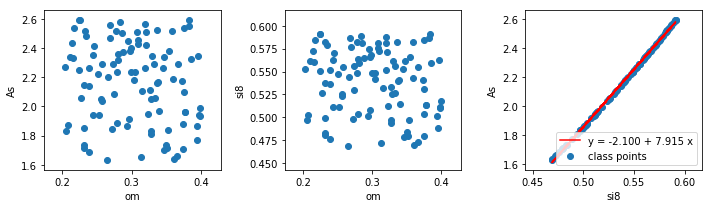

In [183]:
f=figure(figsize=(10,3))
subplot(131)
scatter(om_arr, As_arr*1e9)
xlabel('om');ylabel('As')
subplot(132)
scatter(om_arr, si8_arr)
xlabel('om');ylabel('si8')
subplot(133)
scatter(si8_arr, As_arr*1e9,label='class points')
plot(si8_arr, a+b*si8_arr, 'r-',label='y = %.3f + %.3f x' % (a,b))
legend()
xlabel('si8');ylabel('As')
plt.tight_layout()


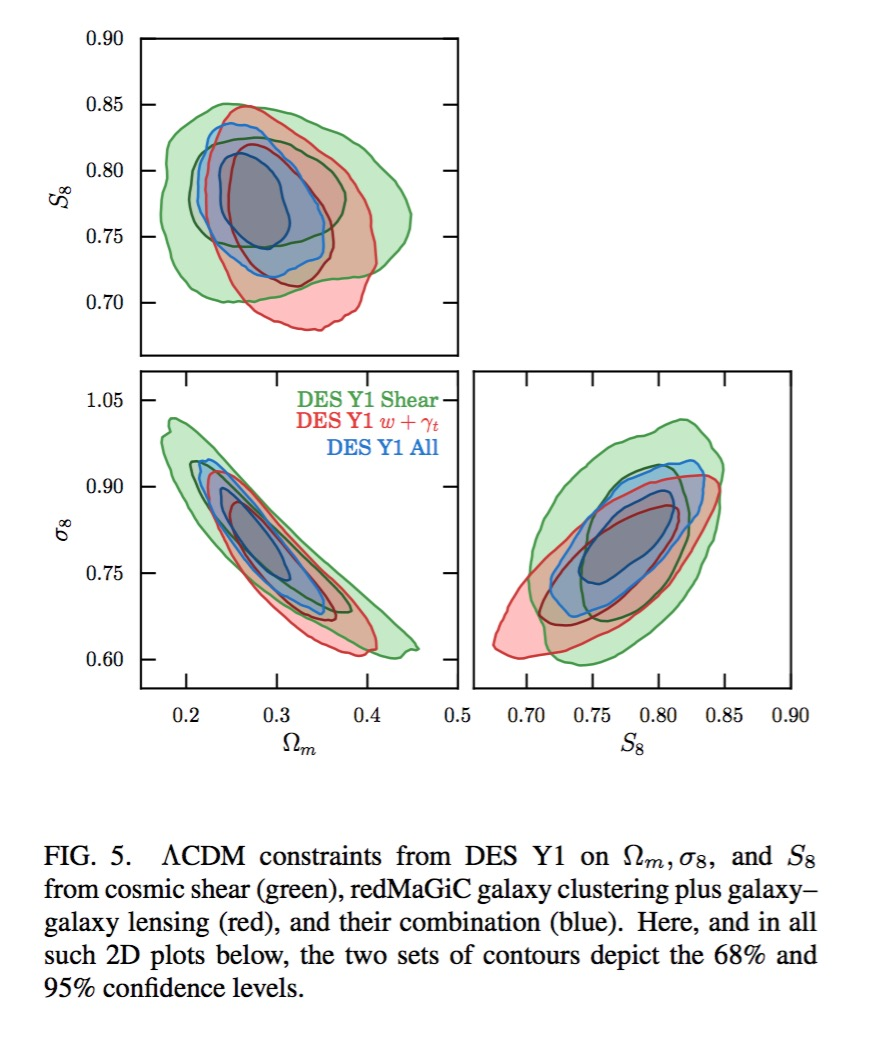

In [75]:
###### 5s per map, need 28 cores finish in 1 hr?
from IPython.display import Image
Image(filename='DES_Y1.jpg',width=300) 

In [84]:
seed(50)
S8_arr = (rand(100)-0.5)*0.12+0.773
si8B_arr = S8_arr/sqrt(om_arr/0.3) #S8=σ8(Ωm/0.3)0.5

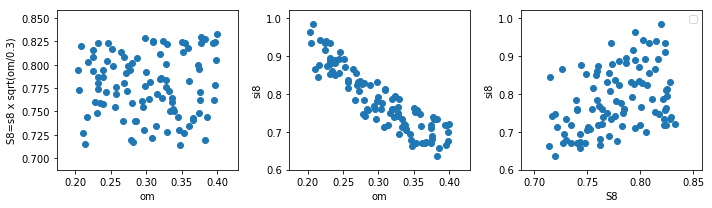

In [85]:
f=figure(figsize=(10,3))
subplot(131)
scatter(om_arr, S8_arr)
xlabel('om');ylabel('S8=s8 x sqrt(om/0.3)')
subplot(132)
scatter(om_arr, si8B_arr)
xlabel('om');ylabel('si8')
subplot(133)
scatter(S8_arr, si8B_arr)
#plot(si8_arr, a+b*si8_arr, 'r-',label='y = %.2f + %.2f x')
legend()
xlabel('S8');ylabel('si8')
plt.tight_layout()

# Generate GRF with known power spectrum

In [87]:
from lenstools import GaussianNoiseGenerator
from astropy.units import deg

In [88]:
num_pixel_side = 256
side_angle = 4.27 * deg

gen = GaussianNoiseGenerator(shape=(num_pixel_side,num_pixel_side),side_angle=side_angle,label="convergence")
gaussian_map = gen.fromConvPower(np.array([ell,clkk]),seed=1,kind="linear",bounds_error=False,fill_value=0.0)

gaussian_map.save('test_GRF.fits')

In [104]:
from astropy.io import fits
x=fits.open('test_GRF.fits')
x[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
ANGLE   =                 4.27 / angle of the map in degrees                    

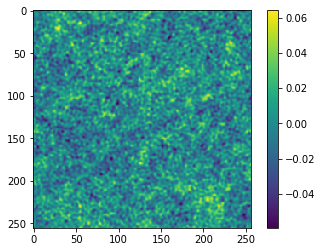

In [105]:
imshow(x[0].data)
colorbar()

In [204]:
## As*1e9=a+b*si8
## y = -2.100 + 7.915 x

num_pixel_side = 256
side_angle = 4.27 * deg ## 1 arcmin/pixel

gen = GaussianNoiseGenerator(shape=(num_pixel_side,num_pixel_side),side_angle=side_angle,label="convergence")


A_se9_find = lambda om, S8: -2.1+7.915*S8/sqrt(om/0.3) 

def GRF_from_PS (omS8seed, zs=1.0):
    om, S8, iseed = omS8seed
    A_se9 = A_se9_find(om, S8)
    si8, ell, clkk = clkk_gen (om, A_se9, zs=1.0)
    gaussian_map = gen.fromConvPower(np.array([ell,clkk]),seed=iseed,kind="linear",bounds_error=False,fill_value=0.0)
    gaussian_map.save('GRF_si%.4f_om%.4f.fits'%(si8, om))
    save('clkk_si%.4f_om%.4f.npy'%(si8, om),[ell, clkk])
    return iseed, om, si8, S8, A_se9

# Test Code before mass production

In [125]:
########## check if everything is ok
out = GRF_from_PS( [0.29,0.77, 10])

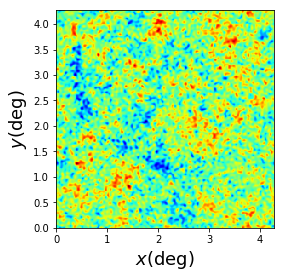

In [141]:
from lenstools import ConvergenceMap

iseed, om, si8, S8, A_se9 = out

iconv_map = ConvergenceMap.load('GRF_si%.4f_om%.4f.fits'%(si8, om))
#imap = fits.open('GRF_si%.4f_om%.4f.fits'%(si8, om))[0].data
iell, iclkk = load('clkk_si%.4f_om%.4f.npy'%(si8, om))
iell_test,iclkk_test= iconv_map.powerSpectrum(linspace(50,5000))
iconv_map.visualize()

Text(0.5,1,'2020/3/12 Clkk test (z_s=1)')

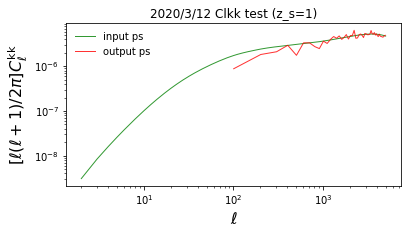

In [144]:
figure(3, figsize=(6,3))
xscale('log');yscale('log');#xlim(2,2500)
xlabel(r'$\ell$',fontsize=16)
ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$',fontsize=16)
plot(iell,iclkk*iell*(iell+1)/2./pi,'g-',lw=1,alpha=0.8,label='input ps')
plot(iell_test,iclkk_test*iell_test*(iell_test+1)/2./pi,'r-',lw=1,alpha=0.8,label='output ps')
#xlim(30,5e4)
legend(loc=0,frameon=0)
title('2020/3/12 Clkk test (z_s=1)')

# Generate 20k parameters in S8, Omega_m space

In [184]:
seed(94720)
S8_arr = (rand(20000)-0.5)*0.4+0.77
om_arr = (rand(20000) - 0.5)*0.4 + 0.27
#A_se9_find = lambda om, S8: -2.1+7.915*S8/sqrt(om/0.3) 
A_se9_arr = A_se9_find(om_arr, S8_arr)
si8B_arr = S8_arr/sqrt(om_arr/0.3) #S8=σ8(Ωm/0.3)0.5

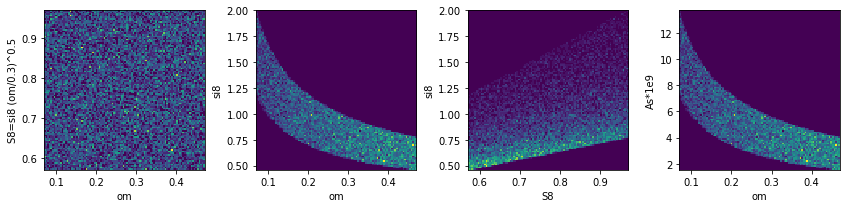

In [185]:
f=figure(figsize=(12,3))
subplot(141)
hist2d(om_arr, S8_arr,bins=100)
xlabel('om');ylabel('S8=si8 (om/0.3)^0.5')
subplot(142)
hist2d(om_arr, si8B_arr,bins=100)
xlabel('om');ylabel('si8')
subplot(143)
hist2d(S8_arr, si8B_arr,bins=100)
xlabel('S8');ylabel('si8')
subplot(144)
hist2d(om_arr, A_se9_arr,bins=100)
xlabel('om');ylabel('As*1e9')
plt.tight_layout()

In [188]:
savetxt('GRF_params.txt',array([om_arr, S8_arr, A_se9_arr]).T, header='om\tS8\tAs*1e9')

In [189]:
amin(A_se9_arr)

1.5384931143228782

In [192]:
inputs=array([om_arr,S8_arr, arange(len(om_arr))]).T
inputs.shape

(20000, 3)

Text(0.5,1,'2020/3/13 Clkk test (z_s=1)')

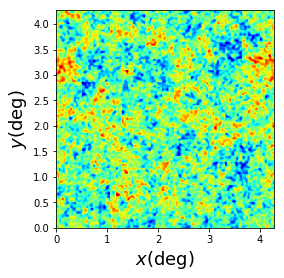

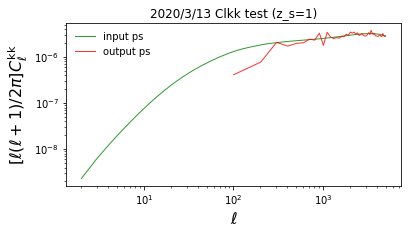

In [196]:
###### test batch python code output
#si8, om = 0.3372, 0.3307
si8, om = 0.2739, 0.2182
iconv_map = ConvergenceMap.load('GRFs/GRF_si%.4f_om%.4f.fits'%(si8, om))
#imap = fits.open('GRF_si%.4f_om%.4f.fits'%(si8, om))[0].data
iell, iclkk = load('cls/clkk_si%.4f_om%.4f.npy'%(si8, om))
iell_test,iclkk_test= iconv_map.powerSpectrum(linspace(50,5000))
iconv_map.visualize()

figure(3, figsize=(6,3))
xscale('log');yscale('log');#xlim(2,2500)
xlabel(r'$\ell$',fontsize=16)
ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$',fontsize=16)
plot(iell,iclkk*iell*(iell+1)/2./pi,'g-',lw=1,alpha=0.8,label='input ps')
plot(iell_test,iclkk_test*iell_test*(iell_test+1)/2./pi,'r-',lw=1,alpha=0.8,label='output ps')
#xlim(30,5e4)
legend(loc=0,frameon=0)
title('2020/3/13 Clkk test (z_s=1)')

# Test output of mass production

In [207]:
iseed_out, om_out, si8_out, S8_out, A_se9_out = loadtxt('GRF_params_output.txt').T

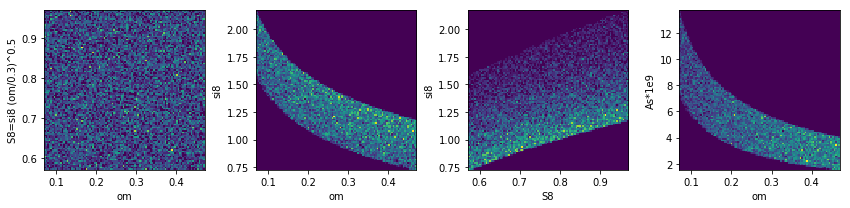

In [208]:
f=figure(figsize=(12,3))
subplot(141)
hist2d(om_out, S8_out,bins=100)
xlabel('om');ylabel('S8=si8 (om/0.3)^0.5')
subplot(142)
hist2d(om_out, si8_out,bins=100)
xlabel('om');ylabel('si8')
subplot(143)
hist2d(S8_out, si8_out,bins=100)
#hist2d(S8_out, S8_out/sqrt(om_out/0.3),bins=100)
xlabel('S8');ylabel('si8')
subplot(144)
hist2d(om_out, A_se9_out,bins=100)
xlabel('om');ylabel('As*1e9')
plt.tight_layout()

In [206]:
## operation on stampede
# tar -cvf ~/scratch/Outlier/GRFs.tar ~/scratch/Outlier/GRFs
# scp ~/scratch/Outlier/GRFs.tar dl:~/www/columbialensing/outlier/
# scp ~/work/Outlier/GRF_params_output.txt dl:~/www/columbialensing/outlier/
# scp ~/scratch/Outlier/GRFs/GRF_014347.fits dl:~/www/columbialensing/outlier

Text(0.5,1,'2020/3/14 Clkk test (z_s=1) model #000999')

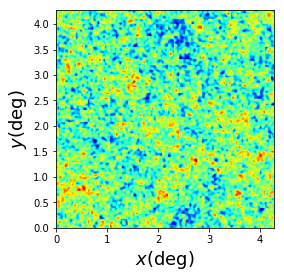

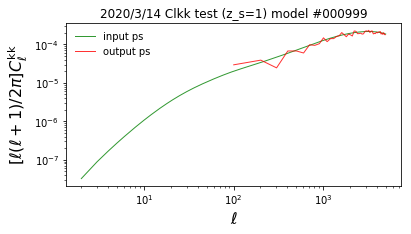

In [212]:
iconv_map = ConvergenceMap.load('GRFs/GRF_000999.fits')
#imap = fits.open('GRF_si%.4f_om%.4f.fits'%(si8, om))[0].data
iell, iclkk = load('cls/clkk_000999.npy')
iell_test,iclkk_test= iconv_map.powerSpectrum(linspace(50,5000))
iconv_map.visualize()

figure(3, figsize=(6,3))
xscale('log');yscale('log');#xlim(2,2500)
xlabel(r'$\ell$',fontsize=16)
ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$',fontsize=16)
plot(iell,iclkk*iell*(iell+1)/2./pi,'g-',lw=1,alpha=0.8,label='input ps')
plot(iell_test,iclkk_test*iell_test*(iell_test+1)/2./pi,'r-',lw=1,alpha=0.8,label='output ps')
#xlim(30,5e4)
legend(loc=0,frameon=0)
title('2020/3/14 Clkk test (z_s=1) model #000999')